In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from pandas import DataFrame
from matplotlib.dates import drange
from sqlalchemy import func, and_
from sqlalchemy import desc

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
conn = engine.connect()

# Exploratory Precipitation Analysis

In [10]:
Measurement_data = pd.read_sql("SELECT * FROM measurement", conn)
Measurement_data

,id,station,date,prcp,tobs
0,0,USC00519397,2010-01-01,2.0,18.3
1,1,USC00519397,2010-01-02,0.0,17.2
2,2,USC00519397,2010-01-03,0.0,23.3
3,3,USC00519397,2010-01-04,0.0,24.4
4,4,USC00519397,2010-01-06,NaN,22.8
...,...,...,...,...,...
19545,19545,USC00516128,2017-08-19,2.3,21.7
19546,19546,USC00516128,2017-08-20,NaN,25.6
19547,19547,USC00516128,2017-08-21,14.2,24.4
19548,19548,USC00516128,2017-08-22,12.7,24.4


In [11]:
Station_data = pd.read_sql("SELECT * FROM station", conn)
Station_data

,id,station,name,latitude,longitude,elevation
0,0,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,0.914
1,1,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,4.450
2,2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,2.133
3,3,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,3.627
4,4,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,93.447
5,5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,5.943
6,6,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,10.027
7,7,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.274
8,8,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,46.449


In [12]:
# Find the most recent date in the data set.
Measurement_data["date"].max()

'2017-08-23'

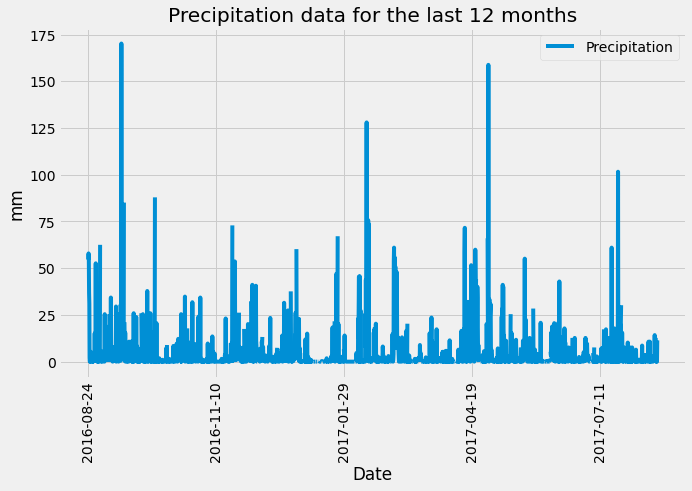

In [13]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results. 
d = dt.datetime(2017, 8, 23)
One_year_prior = d - relativedelta(years=1)


# Perform a query to retrieve the data and precipitation scores
Precip_filter = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > One_year_prior).all()
Precip_filter                   

# Save the query results as a Pandas DataFrame and set the index to the date column
Precip_filter_df = pd.DataFrame(Precip_filter, columns=['Date', 'Precipitation'])
Precip_filter_df.set_index('Date', inplace = True)

# Sort the dataframe by date
Precip_filter_sort_df = Precip_filter_df.sort_values('Date',ascending = True)


# Use Pandas Plotting with Matplotlib to plot the data

Precip_filter_sort_df.plot(figsize = (10,6))
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend(loc = 'best')
plt.title("Precipitation data for the last 12 months")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Precip_filter_df['Precipitation'].describe()

count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
active_stations = Measurement_data.groupby(['station']).count()
active_stations

,id,date,prcp,tobs
station,,,,
USC00511918,1979,1979,1932,1979
USC00513117,2709,2709,2696,2709
USC00514830,2202,2202,1937,2202
USC00516128,2612,2612,2484,2612
USC00517948,1372,1372,683,1372
USC00518838,511,511,342,511
USC00519281,2772,2772,2772,2772
USC00519397,2724,2724,2685,2724
USC00519523,2669,2669,2572,2669


In [16]:
# Design a query to find the most active stations
top_station = active_stations.sort_values("id", axis = 0, ascending = False).head(1)
top_station

# List the stations and the counts in descending order.
station_count = session.query(Measurement.station,\
             func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()
station_count

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_station = session.query(Measurement.station\
                ).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).first()
active_station

('USC00519281')

In [18]:
active_lowest = session.query(func.min(Measurement.tobs),\
                ).filter(Measurement.station == active_station[0]).all()
active_lowest
active_highest = session.query(func.max(Measurement.tobs),\
                ).filter(Measurement.station == active_station[0]).all()
active_highest
active_mean = session.query(func.avg(Measurement.tobs),\
                ).filter(Measurement.station == active_station[0]).all()
active_mean

[(22.03582251082252)]

In [19]:
# Using the most active station id
active_max_date = session.query(func.max(Measurement.date),\
                ).filter(Measurement.station == active_station[0]).all()
active_max_date
d2 = dt.datetime(2017, 8, 18)
active_one_year_prior = d2 - relativedelta(years=1)
active_one_year_prior  
active_last_year = session.query(Measurement.tobs)\
                   .filter(Measurement.date >= active_one_year_prior).filter(Measurement.station == active_station[0])\
                   .order_by(Measurement.tobs.desc()).all()

active_last_year

[(28.3),
 (27.8),
 (27.8),
 (27.8),
 (27.2),
 (27.2),
 (27.2),
 (27.2),
 (27.2),
 (26.7),
 (26.7),
 (26.7),
 (26.7),
 (26.7),
 (26.7),
 (26.7),
 (26.7),
 (26.7),
 (26.7),
 (26.7),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (26.1),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.6),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (25.0),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 (24.4),
 

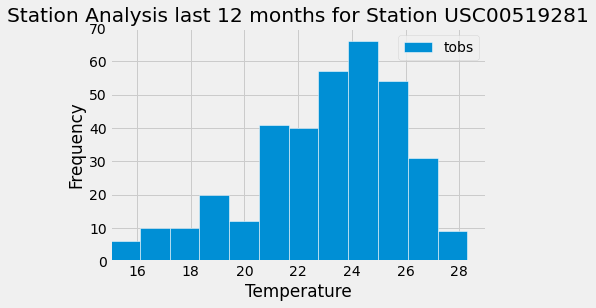

In [20]:
active_last_year_df = pd.DataFrame(active_last_year)
active_last_year_df
fig, ax = plt.subplots()
ax.hist(active_last_year_df['tobs'], bins=12, linewidth=0.5, edgecolor="white")

ax.set(xlim=(15, 29), xticks=np.arange(16, 30,2),
       ylim=(0, 70), yticks=np.linspace(0, 70, 8))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis last 12 months for Station " + active_station[0])
plt.legend(["tobs"])

plt.show()

# Close session

In [22]:
# Close Session
session.close()